# Logistic Regression

Suppose we wish to predict the probability that an example belongs to one of two classes. More specifically, given two classes which we denote blandly by $Y=0$ and $Y=1$, what is the probability that some example belongs to category $Y=1$? The example is characterized by the feature set $X$ and the model is parameterized by $\theta$. Then

$$ \;\;\;\;\;\;\;\; \log \frac {p(Y=1)}{1 - p(Y=1)} = X^T \theta \;\;\;\;\;\;\;\; (1)$$

Working through the mathematics reveals

$$ \frac {p(Y=1)}{1 - p(Y=1)} = \exp \left( X^T \theta \right)$$

$$ p(Y=1) = \exp \left( X^T \theta \right) \left( 1 - p(Y=1) \right)$$

$$ p(Y=1) + \exp \left( X^T \theta \right) p(Y=1)  = \exp \left( X^T \theta \right)$$

$$ p(Y=1) = \frac {\exp \left( X^T \theta \right)} {1 + \exp \left( X^T \theta \right)}$$

$$ \;\;\;\;\;\;\;\; p(Y=1) = \frac 1 {1 + \exp \left( - X^T \theta \right)} \;\;\;\;\;\;\;\; (2)$$

This is the logistic, or sigmoid, function, given in general by

$$ \;\;\;\;\;\;\;\; \sigma(z) = \frac 1 {1 +\exp(-z)} \;\;\;\;\;\;\;\; (3)$$

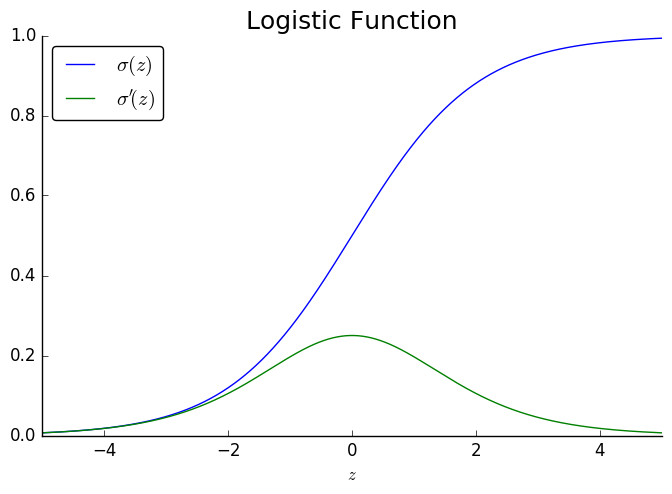

In [1]:
z = linspace(-5,5,10001)
σ(x) = 1./(1+exp(-x))

using PyPlot
fig = figure(figsize=(8,5))
ax = axes()
plot(z, σ(z), label=L"$\sigma(z)$")
plot(z, σ(z).*(1-σ(z)), label=L"$\sigma'(z)$")

ax[:set_xlim]([-5,5])

xlabel(L"$z$")
title("Logistic Function", fontsize=18.0)

legend(loc="best",fancybox="true")

ax[:spines]["top"][:set_color]("none")
ax[:spines]["right"][:set_color]("none")
ax[:xaxis][:set_ticks_position]("bottom")
ax[:yaxis][:set_ticks_position]("left")

It has a very nice derivative

$$ \sigma'(z) = \frac d {dz} \left( 1 + \exp(-z) \right)^{-1}$$

$$ \sigma'(z) = \exp(-z) \left( 1 + \exp(-z) \right)^{-2}$$

$$ \sigma'(z) = \frac {\exp(-z)} {\left( 1 + \exp(-z) \right)^{2}}$$

$$ \sigma'(z) = \frac {1 + \exp(-z) - 1} {\left( 1 + \exp(-z) \right)^{2}}$$

$$ \sigma'(z) = \frac {1} { 1 + \exp(-z)} - \frac {1} {\left( 1 + \exp(-z) \right)^{2}}$$

$$ \sigma'(z) = \sigma(z) \left( 1 - \frac {1} {1 + \exp(-z) } \right)$$

$$  \;\;\;\;\;\;\;\; \;\;\;\;\;\;\;\;   \sigma'(z) = \sigma(z) \left( 1 - \sigma(z) \right) \;\;\;\;\;\;\;\; (4)$$

This is very convenient as once we know $\sigma(z)$ we can determine $\sigma'(z)$ with miniscule additional effort.

## A Cost Function for Logistic Regression

### Squared Error

Let's work out a squared error cost function for logistic regression.

$$J(\theta) = \epsilon^T \epsilon = (\mathsf Y - \sigma(\mathsf X \theta))^2$$

Seems simple enough. But let's do an example to be 100% certain. Consider two populations, $A$ which is normally distributed with mean $-1$ and standard deviation $1$ and $B$ with mean $1$ and standard deviation $1$. We'll use two unknowns equivalent to a slope and intercept of linear regression.

In [10]:
n = 1000
A = [-1 + randn(n) ones(n) zeros(n)]
B = [1 + randn(n) ones(n) ones(n)]

X = [A[:, 1:2]; B[:, 1:2]]
Y = [A[:, 3]; B[:, 3]]

println("OK")

OK


These two populations, categorized as $0$s and $1$s, would look something like the following when plotted:

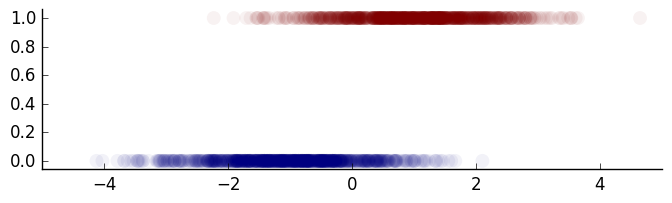

In [11]:
using PyPlot
fig = figure(figsize=(8,2))
ax = axes()
scatter(X[:,1], Y, s=100, c=Y, linewidth=0, alpha=0.05)

ax[:set_xlim]([-5,5])
ax[:set_ylim]([-0.06,1.06])

legend(loc="best",fancybox="true")

ax[:spines]["top"][:set_color]("none")
ax[:spines]["right"][:set_color]("none")
ax[:xaxis][:set_ticks_position]("bottom")
ax[:yaxis][:set_ticks_position]("left")

Let's plot the cost function surface for a two parameter logistic regression model (directly on the training data)

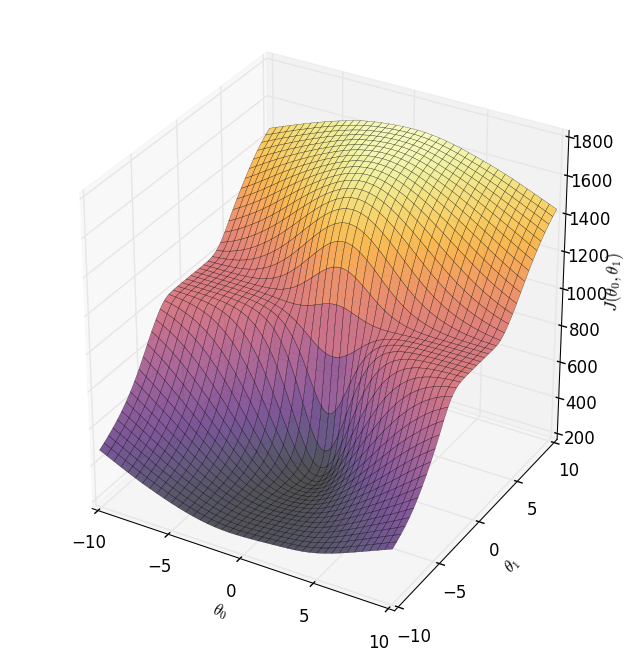

In [12]:
n = 1001
θ⁰ = linspace(-10, 10, n)
θ¹ = linspace(-10, 10, n)

x = repmat(θ⁰, 1, n)
y = repmat(transpose(θ¹), n, 1)

J = zeros(x)
for i = 1:size(θ⁰)[1]
    for j = 1:size(θ¹)[1]
        θ = [θ¹[j]; θ⁰[i]]
        J[i, j] = sum((Y-σ(-X*θ)).^2)
    end
end

using PyPlot
fig = figure(figsize=(8,8))
ax = axes()
surf(x, y, J, rstride=25, cstride=25, cmap="inferno", linewidth=0.25, antialiased=true, alpha=0.67)

xlabel(L"$\theta_0$")
ylabel(L"$\theta_1$")
zlabel(L"$J(\theta_0, \theta_1)$")

ax[:spines]["top"][:set_color]("none")
ax[:spines]["right"][:set_color]("none")
ax[:xaxis][:set_ticks_position]("bottom")
ax[:yaxis][:set_ticks_position]("left")

The surface looks nothing like a parabola. There are wide plateaus of little slope quite far from the minimum; a gradient descent algorithm could conceivably stall on one of those plateaus. What we do not see is more than one minimum. There is no evidence from this example that multiple local minima is an obstacle to the successful use of squared error as the logistic regression cost function.

### Gradient Descent for a Squared Error Cost Function

Actually, where is the minimum precisely? Let's try to find it using gradient descent.

The squared error cost function at the point $\theta_0$ is given by

$$J(\theta) = \left(\mathsf Y - \sigma(\mathsf X \theta) \right)^T \left(\mathsf Y - \sigma(\mathsf X \theta) \right)$$

Aside: how does one take the derivatve of the vector $\sigma(\mathsf X \theta)$ with respect to the vector $\theta$? $\sigma(\mathsf X \theta)$ is a $m \times 1$ vector, whereas $\theta$ is a $n \times 1$ vector. So we would expect the derivative $\frac { d \sigma(\mathsf X \theta)} {d \theta}$ to be a $m \times n$ matrix.

The derivative of the scalar $\sigma(z)$ is given in Eq(4). For this vector case we find empirically the thing that works to be

$$\frac { d \sigma(\mathsf X \theta)} {d \theta} = \sigma(\mathsf X \theta) \left( \mathsf 1 - \sigma(\mathsf X \theta ) \right)^T \mathsf X$$

(There's not a lot of well-known mathematical theory to justify anything we're doing here. It's really a matter of finding what structures produce matrices and vectors of correct dimension, then using them.)

Thus the gradient becomes

$$\nabla_\theta J(\theta) = - 2 \left(\mathsf Y - \sigma(\mathsf X \theta) \right)^T \sigma(\mathsf X \theta) \left( \mathsf 1 - \sigma(\mathsf X \theta) \right)^T \mathsf X$$

[-1.88497,-7.43139]
[-1.97486,-8.35238]
[-2.2253,-9.95682]
[-2.65846,-12.0665]
[-3.56462,-16.0401]
[-6.56732,-28.7471]


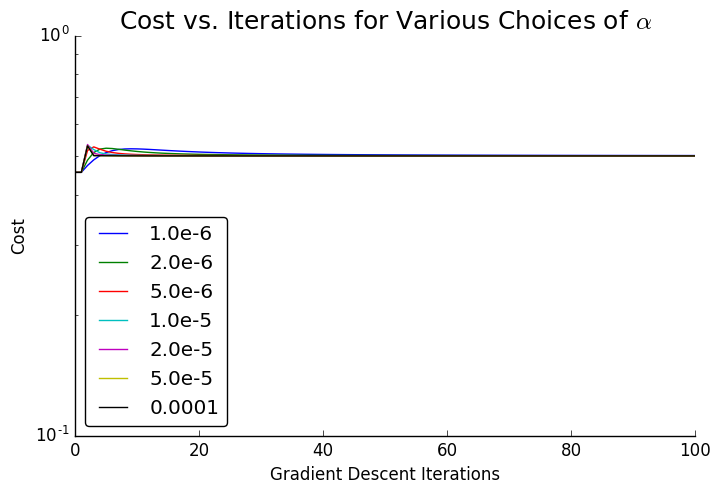

[-11.8967,-51.0431]


In [24]:
θ⁰ = randn(size(X)[2])

using PyPlot
fig = figure(figsize=(8,5))
ax = axes()
tmax = 100
for α in [0.000001, 0.000002, 0.000005, 0.00001, 0.00002, 0.00005, 0.0001]
    θ = θ⁰
    SqEs = []
    p = σ(X*θ)
    push!(SqEs, mean((Y - p).^2))
    for t = 1:tmax
        p = σ(X*θ)
        θ = θ  + 2*α*transpose(X)*(ones(p)-p)*transpose(p)*(Y-p)
        push!(SqEs, mean((Y - p) .^2))
    end
    println(θ)
    plot(0:tmax, SqEs, label="$α")
end

ax[:set_yscale]("log")
xlabel("Gradient Descent Iterations")
ylabel("Cost")
title(L"Cost vs. Iterations for Various Choices of $\alpha$", fontsize=18.0)

legend(loc="best",fancybox="true")

ax[:spines]["top"][:set_color]("none")
ax[:spines]["right"][:set_color]("none")
ax[:xaxis][:set_ticks_position]("bottom")
ax[:yaxis][:set_ticks_position]("left")

Gradient descent with a squared error cosnt function is extremely unstable. The error surface is characterized by regions of very small and very large slope. Depending upon the starting point for $\theta$, you can wind up practically anywhere. We need a better approach.

### Maximum Likelihood: A Theoretically Justified Approach to Finding the Right Cost Function

Maximum likelihood is a means of deriving the most likely parameters that describe a distribution or relationship. Maximum likelihood theory states that the distributional parameters most likely to be correct are those that maximize the product

$$ \;\;\;\;\;\;\;\; L(\theta) = \prod_{i=1}^N {p^{(i)}}^{y^{(i)}} (1 - p^{(i)})^{1-y^{(i)}} \;\;\;\;\;\;\;\; (5)$$

We can find the maximum of $L$ by differentiation with respect to the vector $\theta$. But that's not at all easy considering the form of Eq(5). It turns out that by taking the logarithm on Eq(4) we can produce a log-likelihood function that is substantially easier to work with. And if we negate the logarithm we will have an error function that can be minimized

$$ J(\theta) = - \log L(\theta) = - \sum_{i=1}^N \left( y^{(i)} \log p^{(i)} + (1-y^{(i)}) \log (1 - p^{(i)}) \right)$$

$$ J(\theta) = - \sum_{i=1}^N \left( y^{(i)} \left( \log p^{(i)} - \log (1 - p^{(i)})\right) + \log (1 - p^{(i)}) \right)$$

$$ J(\theta) = - \sum_{i=1}^N \left( y^{(i)} \log \frac {p^{(i)}} {1 - p^{(i)}} + \log (1 -p^{(i)}) \right)$$

Making use of Eq(1) reveals

$$ J(\theta) = - \sum_{i=1}^N \left( y^{(i)} X^{(i)} \theta + \log (1 - p^{(i)}) \right)$$

Substituting Eq(2) for $p^{(i)}$ yields

$$ J(\theta) = - \sum_{i=1}^N \left( y^{(i)} {X^{(i)}}^T \theta + \log \left(1 - \frac 1 {1 + \exp(-{X^{(i)}}^T \theta)}\right) \right)$$

$$ J(\theta) = - \sum_{i=1}^N \left( y^{(i)} {X^{(i)}}^T \theta + \log \frac {\exp(-{X^{(i)}}^T \theta)} {1 + \exp(-{X^{(i)}}^T \theta)} \right)$$

$$ J(\theta) = - \sum_{i=1}^N \left( y^{(i)} {X^{(i)}}^T \theta + \log \frac {\exp(-{X^{(i)}}^T \theta)} {1 + \exp(-{X^{(i)}}^T \theta)} \right)$$

$$ J(\theta) = - \sum_{i=1}^N \left( y^{(i)} {X^{(i)}}^T \theta + \log \frac 1 {1 + \exp({X^{(i)}}^T \theta)} \right)$$

$$ J(\theta) = - \sum_{i=1}^N \left( y^{(i)} {X^{(i)}}^T \theta - \log  \left(1 + \exp({X^{(i)}}^T \theta) \right) \right)$$

$$ \;\;\;\;\;\;\;\; J(\theta) = \sum_{i=1}^N \left( \log  \left(1 + \exp({X^{(i)}}^T \theta) \right) -  y^{(i)} {X^{(i)}}^T \theta  \right) \;\;\;\;\;\;\;\; (6)$$

In vector form Eq(6) becomes

$$ J(\theta) = \mathsf 1^T \log  \left(\mathsf 1 + \exp(\mathsf X \theta) \right) -  \mathsf Y^T \mathsf X \theta  $$

If we differentiate the scalar in Eq(6) with respect to the vector $\theta$ we discover

$$  \frac {d J(\theta)}{d \theta}  = \sum_{i=1}^N \left( \frac {\exp({X^{(i)}}^T \theta) {X^{(i)}}^T }  {1 + \exp({X^{(i)}}^T \theta) } -  y^{(i)} {X^{(i)}}^T  \right) $$

$$  \frac {d J(\theta)}{d \theta}  = \sum_{i=1}^N \left( \frac { {X^{(i)}}^T }  {1 + \exp(-{X^{(i)}}^T \theta) } -  y^{(i)} {X^{(i)}}^T  \right) $$

$$  \frac {d J(\theta)}{d \theta}  = \sum_{i=1}^N \left( \sigma \left( {X^{(i)}}^T \theta \right) {X^{(i)}}^T  -  y^{(i)} {X^{(i)}}^T  \right) $$

$$  \frac {d J(\theta)}{d \theta}  = \sum_{i=1}^N \left( \sigma \left( {X^{(i)}}^T \theta \right)  -  y^{(i)} \right)  {X^{(i)}}^T  $$

Written in vector form this equation becomes

$$ \;\;\;\;\;\;\;\; \nabla_\theta J(\theta)  = \left( \sigma \left( \mathsf X \theta \right)  -  \mathsf Y \right)^T  \mathsf X  \;\;\;\;\;\;\;\; (7)$$

The value of the vector $\theta$ that minimizes $l(\theta)$ is the one for which the vector  $\sigma \left( \mathsf X \theta \right)  -  \mathsf Y$ is orthogonal to the column space of $\mathsf X$ and as such the gradient is $0.$

Let's try gradient descent with a minimum unlikelihood cost function

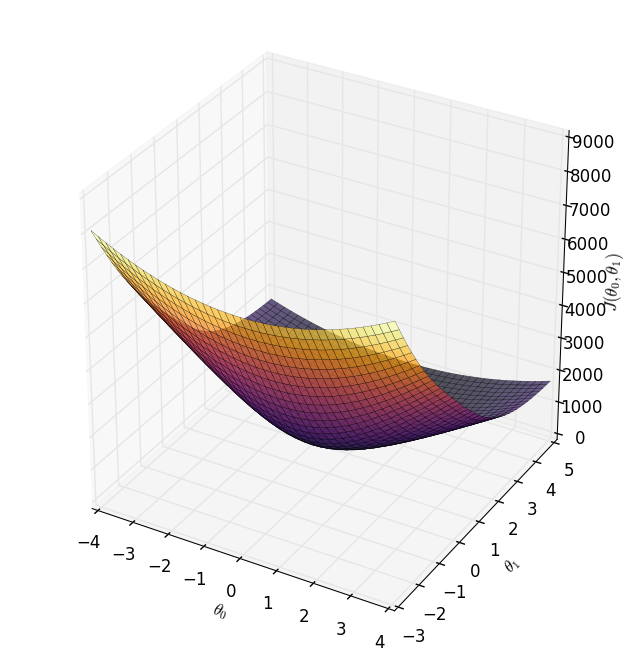

In [32]:
n = 1001
θ⁰ = linspace(-4, 4, n)
θ¹ = linspace(-3, 5, n)

x = repmat(θ⁰, 1, n)
y = repmat(transpose(θ¹), n, 1)

J = zeros(x)
for i = 1:n
    for j = 1:n
        θ = [θ¹[j]; θ⁰[i]]
        J[i, j] = sum(log(1 + exp(X*θ))) - (transpose(Y)*X*θ)[1]
    end
end

using PyPlot
fig = figure(figsize=(8,8))
ax = axes()
surf(x, y, J, rstride=25, cstride=25, cmap="inferno", linewidth=0.25, antialiased=true, alpha=0.67)

xlabel(L"$\theta_0$")
ylabel(L"$\theta_1$")
zlabel(L"$J(\theta_0, \theta_1)$")

ax[:spines]["top"][:set_color]("none")
ax[:spines]["right"][:set_color]("none")
ax[:xaxis][:set_ticks_position]("bottom")
ax[:yaxis][:set_ticks_position]("left")

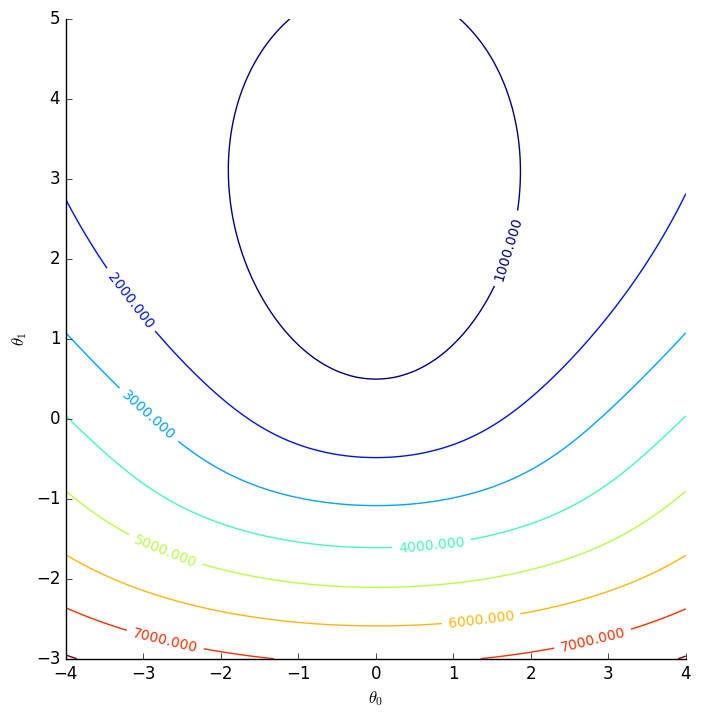

In [33]:
n = 101
θ⁰ = linspace(-4, 4, n)
θ¹ = linspace(-3, 5, n)

x = repmat(θ⁰, 1, n)
y = repmat(transpose(θ¹), n, 1)

J = zeros(x)
for i = 1:n
    for j = 1:n
        θ = [θ¹[j]; θ⁰[i]]
        J[i, j] = sum(log(1 + exp(X*θ))) - (transpose(Y)*X*θ)[1]
    end
end

using PyPlot
fig = figure(figsize=(8,8))
ax = axes()
pl = contour(x, y, J, linewidth=1.0)
ax[:clabel](pl, inline=1, fontsize=10)

xlabel(L"$\theta_0$")
ylabel(L"$\theta_1$")

ax[:spines]["top"][:set_color]("none")
ax[:spines]["right"][:set_color]("none")
ax[:xaxis][:set_ticks_position]("bottom")
ax[:yaxis][:set_ticks_position]("left")

This looks much more convex than the surface associated with the squared error cost function. Let's use this one.

### Gradient Descent for MLE Cost Function

[1.28829,0.0392568]
[1.7447,0.00247954]
[2.02845,-0.0117757]
[2.06362,-0.0125152]
[2.06458,-0.0125279]
[2.06458,-0.0125279]


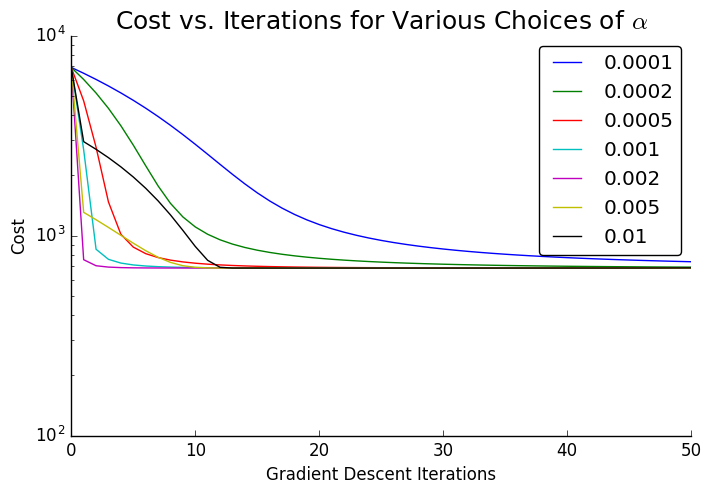

[2.0672,-0.13408]


In [22]:
θ⁰ = randn(size(X)[2])

using PyPlot
fig = figure(figsize=(8,5))
ax = axes()
tmax = 50
for α in [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01]
    θ = θ⁰
    MLEs = []
    p = σ(X*θ)
    push!(MLEs, sum(log(1 + exp(X*θ))) - (transpose(Y)*X*θ)[1])
    for t = 1:tmax
        p = σ(X*θ)
        θ = θ  - α*transpose(X)*(p - Y)
        push!(MLEs, sum(log(1 + exp(X*θ))) - (transpose(Y)*X*θ)[1])
    end
    println(θ)
    plot(0:tmax, MLEs, label="$α")
end

ax[:set_yscale]("log")
xlabel("Gradient Descent Iterations")
ylabel("Cost")
title(L"Cost vs. Iterations for Various Choices of $\alpha$", fontsize=18.0)

legend(loc="best",fancybox="true")

ax[:spines]["top"][:set_color]("none")
ax[:spines]["right"][:set_color]("none")
ax[:xaxis][:set_ticks_position]("bottom")
ax[:yaxis][:set_ticks_position]("left")

### Conjugate Gradient Method for MLE Cost Function

Let's build upon our development of the conjugate gradient method described in [Gradient Descent](http://localhost:8888/notebooks/Algorithms/ML/GradientDescent.ipynb) and focus on logistic regression with a MLE cost function. We will again make judicious use of Einstein Summation Convention.

The gradient of the cost function the point $\theta^{(0)}$ is
$$ \nabla_\theta J(\theta^{(0)})  = \left( \sigma_i  - Y_i \right) X_{ik} $$

where $\sigma_i = \frac 1 {1 + \exp(-X_{ij} \theta_j)}$

We seek the point $\theta^{(1)}$ given by
$$ \theta_j^{(1)}  = \theta_j^{(0)}  - \alpha \left( \sigma_i  - Y_i \right) X_{ij} $$

The gradient of the cost function the point $\theta^{(1)}$ is
$$ \nabla_\theta J(\theta^{(1)})  = \left( \frac 1 {1 + \exp \left (- X_{kj} \left( \theta_j - \alpha (\sigma_i - Y_i) X_{ij} \right) \right)}  - Y_k \right) X_{km} $$

where $\theta$ refers specifically to the point otherwise designated $\theta^{(0)}$.

Now let's find the value of $\alpha$ for which the two gradients are orthogonal

$$ \nabla_\theta J(\theta^{(0)}) \cdot \nabla_\theta J(\theta^{(1)}) = \left( \sigma_m  - Y_m \right) X_{mn} \left( \frac 1 {1 + \exp \left (- X_{kj} \left( \theta_j - \alpha (\sigma_i - Y_i) X_{ij} \right) \right)}  - Y_k \right) X_{km} = 0$$

$$  \frac {\left( \sigma_m  - Y_m \right) X_{mn} X_{kn}} {1 + \exp \left (- X_{kj} \left( \theta_j - \alpha (\sigma_i - Y_i) X_{ij} \right) \right)}  = \left( \sigma_m  - Y_m \right) X_{mn} Y_k X_{kn} $$

$$  \frac  {1 + \exp \left (- X_{kj} \left( \theta_j - \alpha (\sigma_i - Y_i) X_{ij} \right) \right)} {\left( \sigma_m  - Y_m \right) X_{mn} X_{kn}}  = \frac 1 {\left( \sigma_m  - Y_m \right) X_{mn} Y_k X_{kn}} $$

$$  {\exp \left (- X_{kj} \left( \theta_j - \alpha (\sigma_i - Y_i) X_{ij} \right) \right)}  = \frac  {\left( \sigma_m  - Y_m \right) X_{mn} X_{kn}} {\left( \sigma_m  - Y_m \right) X_{mn} Y_k X_{kn}} - 1$$

$$ X_{kj} \left( -\theta_j + \alpha (\sigma_i - Y_i) X_{ij} \right)  = \log \left( \frac  {\left( \sigma_m  - Y_m \right) X_{mn} X_{kn}} {\left( \sigma_m  - Y_m \right) X_{mn} Y_k X_{kn}} - 1 \right)$$

In vectorized form this becomes

$$  \mathsf X \left( \alpha \mathsf X^T {(\sigma - \mathsf Y) } - \theta \right)  = \log \left( \frac {\mathsf X \mathsf X^T \left( \sigma  - \mathsf Y \right) } {\mathsf Y^T \mathsf X \mathsf X ^T \left( \sigma  - \mathsf Y \right)} - \mathsf 1 \right) $$

$$ \alpha \mathsf X^T {(\sigma - \mathsf Y) }   = \left( \mathsf X^T \mathsf X \right)^{-1}  \mathsf X^T \log \left( \frac {\mathsf X \mathsf X^T \left( \sigma  - \mathsf Y \right) } {\mathsf Y^T \mathsf X \mathsf X ^T \left( \sigma  - \mathsf Y \right)} - \mathsf 1 \right) + \theta$$

$$   \alpha  = \frac  {(\sigma - \mathsf Y)^T \mathsf X \left[ \left( \mathsf X^T \mathsf X \right)^{-1}  \mathsf X^T \log \left( \frac {\mathsf X \mathsf X^T \left( \sigma  - \mathsf Y \right) } {\mathsf Y^T \mathsf X \mathsf X ^T \left( \sigma  - \mathsf Y \right)} - \mathsf 1 \right) + \theta \right]}{(\sigma - \mathsf Y)^T \mathsf X \mathsf X^T (\sigma - \mathsf Y)}$$

Yikes!